### Portfolio Backtest
#### This basic portfolio simulation will trade the index constituents of the Dow Jones Industrial Average. For each of the 30 member stocks, we'll check if the price is above or below it's respective 100 day moving average on a daily basis.

#### If the price is above the moving average, we will be long with a notional allocation of 1/30 (3.33%). That means in a perfect bull market, if all 30 stocks are above their respective moving averages, we will have an overall portfolio exposure of 100%.

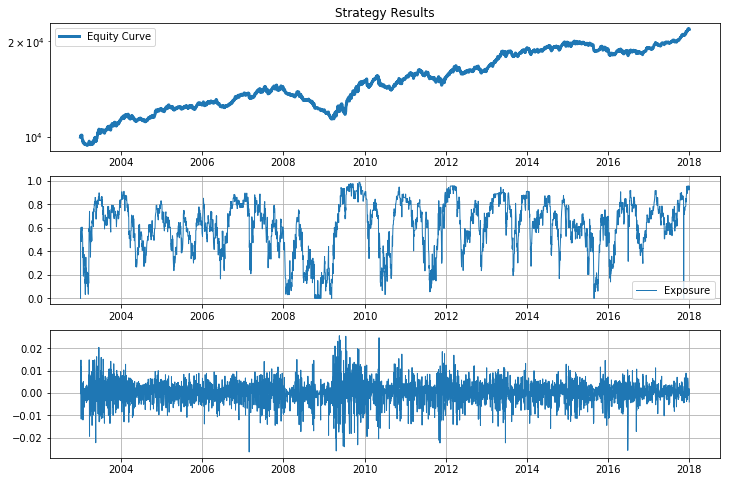

In [3]:
%matplotlib inline
from zipline import run_algorithm
from zipline.api import order_target_percent, record, symbol
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pandas as pd

def initialize(context):
    # Which stocks to trade
    dji = ["AAPL", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS", "DWDP",
          "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
          "MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "UTX", "V",
          "VZ", "WBA", "WMT", "XOM",]
    
    # Make a list of symbols from the list of tickers
    context.dji_symbols = [symbol(s) for s in dji]
    
    # Moving average window
    context.index_average_window = 100
    
def handle_data(context, data):
    # Get historical data for all the stocks
    stock_hist = data.history(context.dji_symbols, "close", context.index_average_window, "1d")
    
    # Make an empty DataFrame to start with
    stock_analytics = pd.DataFrame()
    
    # Add column for above or below average
    stock_analytics['above_mean'] = stock_hist.iloc[-1] > stock_hist.mean()
    
    # Set weight for stocks to buy; it locates(loc) rows where column == 'above_mean' and
    # sets the column 'weight' = 1/len(context.dji_symbols)
    stock_analytics.loc[stock_analytics['above_mean'] == True, 'weight'] = 1/len(context.dji_symbols)
    
    # Set weight to zero for the rest
    stock_analytics.loc[stock_analytics['above_mean'] == False, 'weight'] = 0.0
    
    # Iterate each row and place trades
    for stock, analytics in stock_analytics.iterrows():
        # Check if the stock can be traded
        if data.can_trade(stock):
            # Place the trade
            order_target_percent(stock, analytics['weight'])
            
def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)

    # Second subplot
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third subplot
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-', linewidth=1.0)
    ax.grid(True)
    
# Set start and end date
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2017, 12, 31, tzinfo=pytz.UTC)

# Fire off the backtest
results = run_algorithm(
    start=start,
    end=end, 
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily',
    bundle='quandl'
)